In [2]:
    import pandas as pd
import numpy as np
from glob import glob
import json
import os
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [36]:
rows = []
for path in glob("logs/**/*.json"):
    contents = json.loads(open(path).read())
    normalize = {True:'T', False:'F'}[contents.get('normalize', False)]
    T = {'add': '_ta', 'sub': '_ts', '': ''}[contents.get('normalize_type', '')] if normalize=='T' else '' 
    dic = {
        "model": path.split("/")[1] + f'_n{normalize}{T}'
    }
    if 'latest' in path:
        continue
    dic['epoch'] = int(re.search(r"epoch\_([0-9]+)", path).groups(1)[0])
    n = 4 if 'sugar' in path else 1
    dic['dataset'] = '_'.join(os.path.basename(path).split("_")[0:n])
    dic.update(contents)
    rows.append(dic)
df = pd.DataFrame(rows)
df.head()

df['model'].unique(), df['dataset'].unique()


model_last_epoch = df.groupby('model').max().epoch.to_dict()
df['last_epoch'] = df.model.apply(lambda m:model_last_epoch[m])

/tmp/ipykernel_20198/3716397536.py:22: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  model_last_epoch = df.groupby('model').max().epoch.to_dict()


In [37]:
df

,model,epoch,dataset,acc,acc1,acc5,mean_per_class_recall,normalize,normalizer,normalize_type,last_epoch
0,datacomp_dec_ViT-B-16_ep100_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,8,sugar_crepe_add_obj,0.990786,NaN,NaN,NaN,NaN,NaN,NaN,13
1,datacomp_dec_ViT-B-16_ep100_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,2,sugar_crepe_replace_rel,0.716216,NaN,NaN,NaN,NaN,NaN,NaN,13
2,datacomp_dec_ViT-B-16_ep100_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,1,sugar_crepe_replace_obj,0.713680,NaN,NaN,NaN,NaN,NaN,NaN,13
3,datacomp_dec_ViT-B-16_ep100_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,2,cifar100,NaN,0.4157,0.6540,0.4159,NaN,NaN,NaN,13
4,datacomp_dec_ViT-B-16_ep100_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,8,sugar_crepe_replace_obj,0.763923,NaN,NaN,NaN,NaN,NaN,NaN,13
...,...,...,...,...,...,...,...,...,...,...,...
889,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,4,cifar10,NaN,0.7557,0.9866,0.7557,NaN,NaN,NaN,4
890,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta,3,sugar_crepe_swap_obj,0.764228,NaN,NaN,NaN,True,microsoft/phi-2,add,4
891,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,1,sugar_crepe_replace_rel,0.665007,NaN,NaN,NaN,NaN,NaN,NaN,4
892,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,4,sugar_crepe_replace_rel,0.709104,NaN,NaN,NaN,NaN,NaN,NaN,4


# Leaderboard

In [38]:
df[ (df.dataset=='imagenet1k') & (df.epoch==df.last_epoch)].sort_values(by='acc1', ascending=False)[['model', 'acc1']].round(3)

,model,acc1
566,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.628
359,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.594
702,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.548
151,datacomp_dec_vision_dinov2s14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.513
507,datacomp_dec_b32_vision_datacomp_xl_s13b_b90k_text_scratch_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.402
639,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.373
263,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.321
736,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs256_nF,0.321
881,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.318
38,datacomp_dec_ViT-B-16_ep100_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.291


In [39]:
df[ (df.dataset=='sugar_crepe_swap_obj') & (df.epoch==df.last_epoch)].sort_values(by='acc', ascending=False)[['model', 'acc']].round(3)

,model,acc
570,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta,0.780
642,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.768
696,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta,0.768
358,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta,0.756
562,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.744
663,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta,0.740
137,datacomp_dec_ViT-B-16_ep100_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta,0.732
475,datacomp_dec_b32_vision_datacomp_xl_s13b_b90k_text_scratch_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.728
520,datacomp_dec_b32_vision_datacomp_xl_s13b_b90k_text_scratch_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta,0.728
172,datacomp_dec_vision_dinov2s14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta,0.724


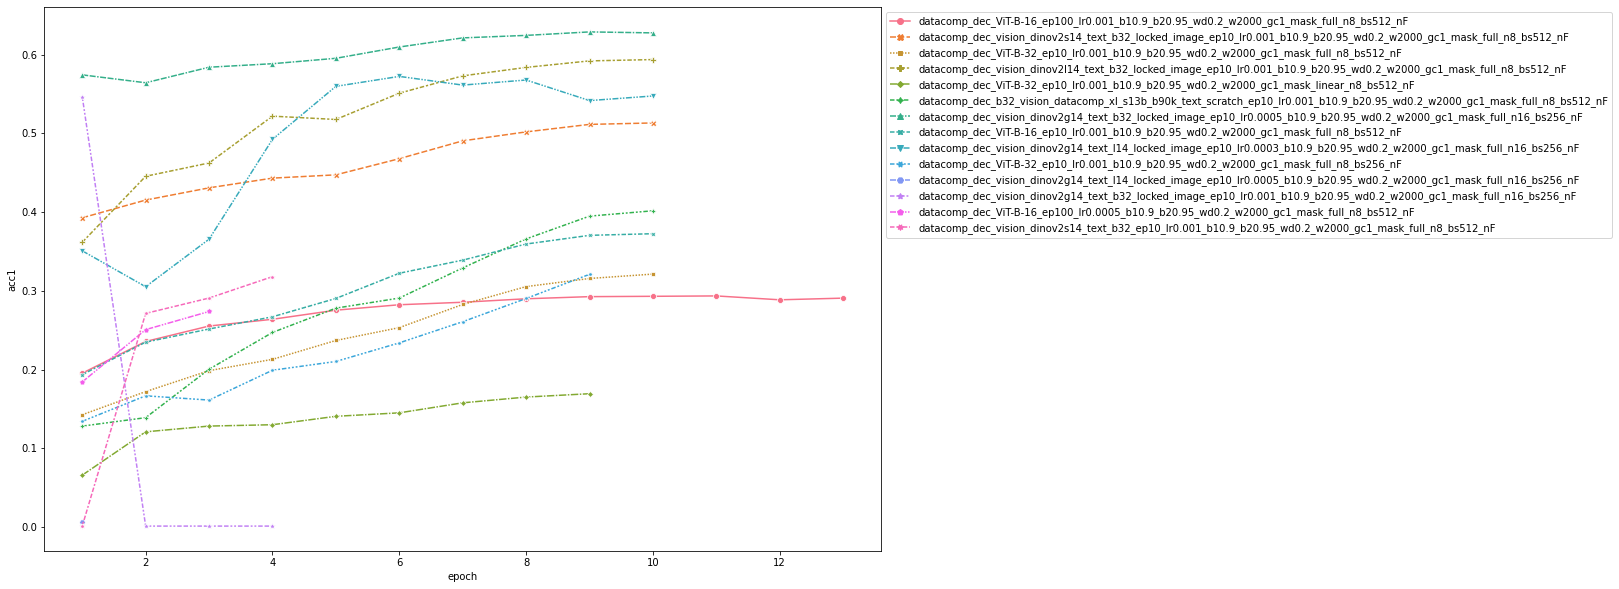

In [40]:
ds = 'imagenet1k'
fig = plt.figure(figsize=(15,10))
sns.lineplot(x='epoch', y='acc1', hue='model', data=df[df.dataset==ds], style='model', markers=True)
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.show()

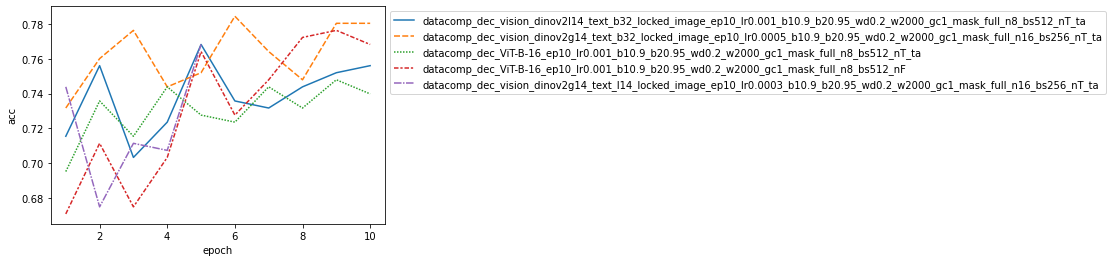

In [45]:
ds = 'sugar_crepe_swap_obj'
d = df[df.dataset==ds]
ms = [
'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta',
'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta',
'datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta',
'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta',
'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
]
d = d[d.model.isin(ms)]
sns.lineplot(x='epoch', y='acc', hue='model', data=d, style='model')
plt.legend(loc='best', bbox_to_anchor=(1,1))
#plt.xticks(np.arange(1, df.epoch.max()+1))
plt.show()